# Create the multilayer network for the Tokyo Area

Using the `multilayer_network_tools.py` module we have created, make the network on the Tokyo metropolitan area. 

In [1]:
# import libraries
import os
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import gtfs_segments
import osmnx as ox

# import helper functions
from multilayer_network_tools import *

In [2]:
# set crs for Tokyo
crs = 'EPSG:6677'

# load geometry for the area of interest
tokyo_geom = gpd.read_file(os.path.join('data', 'tokyo_boundaries', 'N03-20240101_13.shp'))
tokyo_geom = tokyo_geom[tokyo_geom['N03_004'].str.contains('区')].copy().to_crs(crs)

## Load bus data

Using the data for

- [Toei Bus](https://ckan.odpt.org/dataset/b_bus_gtfs_jp-toei/resource/171a583d-4bf3-4f71-ae57-16f2140babda)
- [Keio Bus](https://ckan.odpt.org/dataset/keio_bus_all_lines/resource/05e74842-50f2-487f-bd46-de30fc93d3f8)
- [Kanto Bus](https://ckan.odpt.org/dataset/kanto_bus_all_lines/resource/2b52c244-5e6c-4d26-adf0-1a19b326f420)
- [Seibu Bus](https://ckan.odpt.org/dataset/seibu_bus__b-bus_gtfs/resource/8a2d63ed-6023-42bf-ae34-1796c56f607f)

In [3]:
# set path to the zip file and the unfrozen file
zip_path = os.path.join('data', 'tokyo', 'ToeiBus-GTFS.zip')
fp = os.path.join('data', 'tokyo', 'ToeiBus-GTFS')

# load data
shapes = pd.read_csv(os.path.join(fp, 'shapes.txt'))
routes = pd.read_csv(os.path.join(fp, 'routes.txt'))
stops = pd.read_csv(os.path.join(fp, 'stops.txt'))
stop_times = pd.read_csv(os.path.join(fp, 'stop_times.txt'))
trips = pd.read_csv(os.path.join(fp, 'trips.txt'))
translations = pd.read_csv(os.path.join(fp, 'translations.txt'))

In [4]:
# add translations
# extract English Translations
translations = translations[translations['language'] == 'en']

In [5]:
# merge with stops
stops = stops.merge(
    translations[translations['table_name'] == 'stops'][['record_id', 'translation']],
    how = 'left', 
    left_on = 'stop_id',
    right_on = 'record_id'
).drop(columns = 'record_id').rename(columns = {'translation': 'stop_name_en'})

In [6]:
# create GeoDataFrame for stops
stops_gdf = gpd.GeoDataFrame(
    stops,
    geometry = gpd.points_from_xy(stops['stop_lon'], stops['stop_lat']),
    crs = 'EPSG:4326'
).to_crs(crs)

In [7]:
# add coordinates to the stops
stops_gdf['x'] = stops_gdf['geometry'].x
stops_gdf['y'] = stops_gdf['geometry'].y

In [8]:
# filter by union
stops_gdf_tokyo = stops_gdf[stops_gdf.intersects(tokyo_geom.unary_union)]

In [9]:
# create segments from GTFS using gtfs_segments
bus_edges = gtfs_segments.get_gtfs_segments(zip_path).to_crs(crs)

Using the busiest day: 2024-05-15
Excluding Trips with no shape_id: ['00407-2-01-179-2230', '48111-1-53-170-0630', '48111-1-53-170-0726', '48111-1-53-170-0830', '48111-1-53-170-1017', '48111-1-53-170-1113', '48111-1-53-170-1305', '48111-1-53-170-1555', '48111-2-53-170-0703', '48111-2-53-170-0759', '48111-2-53-170-0853', '48111-2-53-170-1040', '48111-2-53-170-1140', '48111-2-53-170-1330', '48111-2-53-170-1620', '72813-1-85-170-2146']


c:\Users\Soki\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in parse_integer (vectorized)
  outputs = ufunc(*inputs)


Excluding Trip: 00302-2-06-170-0941 because of failed snap!
Excluding Trip: 65401-2-69-170-0830 because of failed snap!
Total trips processed:  14151
Total defective trips:  46
Percentage defective trips: 0.33%


In [10]:
# merge with route name
bus_edges['route_id'] = bus_edges['route_id'].astype(int)

bus_edges = bus_edges.merge(
    right = routes[['route_id', 'route_short_name', 'route_color']],
    on = 'route_id',
    how = 'left'
)

# merge with name of stop
bus_edges = bus_edges.merge(
    stops[['stop_id', 'stop_name']],
    how = 'left',
    left_on = 'stop_id1',
    right_on = 'stop_id'
).drop(columns = ['stop_id']).rename(columns = {'stop_name': 'source_name'}).merge(
    stops[['stop_id', 'stop_name']],
    how = 'left',
    left_on = 'stop_id2',
    right_on = 'stop_id'
).drop(columns = ['stop_id']).rename(columns = {'stop_name': 'target_name'})

# round distance to meters
bus_edges['distance'] = bus_edges['distance'].round()

In [11]:
# remove the rural areas
bus_edges = bus_edges[~bus_edges['route_short_name'].str.contains('梅')]

In [35]:
bus_edges.head(5)

,segment_id,route_id,direction_id,trip_id,traversals,distance,stop_id1,stop_id2,traversal_time,speed,geometry,route_short_name,route_color,source_name,target_name
0,0302-03-2546-01-1,2,1.0,04601-1-85-170-0640,41,326.0,0302-03,2546-01,60.0,5.426500,"LINESTRING (-5308.519 -42032.483, -5312.656 -4...",波０１（ＮＭ０１）,F1B34E,東京国際クルーズターミナル駅前,日本科学未来館前
1,2326-05-0302-03-1,2,1.0,04601-1-85-170-0640,41,985.0,2326-05,0302-03,60.0,16.408833,"LINESTRING (-4890.654 -41367.848, -4887.063 -4...",波０１（ＮＭ０１）,F1B34E,東京テレポート駅前,東京国際クルーズターミナル駅前
2,2327-01-2542-01-1,2,1.0,04601-1-85-170-0640,41,328.0,2327-01,2542-01,0.0,inf,"LINESTRING (-4931.107 -42449.722, -4926.958 -4...",波０１（ＮＭ０１）,F1B34E,テレコムセンター駅前,青海二丁目
3,2327-02-2407-05-1,2,0.0,04601-2-85-170-0701,45,344.0,2327-02,2407-05,60.0,5.728667,"LINESTRING (-4875.201 -42431.205, -4879.325 -4...",波０１（ＮＭ０１）,F1B34E,テレコムセンター駅前,東京港湾合同庁舎前
4,2407-04-2327-01-1,2,1.0,04601-1-85-170-0640,41,295.0,2407-04,2327-01,240.0,1.229917,"LINESTRING (-5164.270 -42432.283, -5161.529 -4...",波０１（ＮＭ０１）,F1B34E,東京港湾合同庁舎前,テレコムセンター駅前


In [39]:
stops_gdf_tokyo.head(5)

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,platform_code,stop_name_en,geometry,x,y
0,0001-01,NaN,愛育クリニック前,NaN,35.653697,139.726017,0001-01,https://tobus.jp/blsys/navi?LCD=&VCD=cresultrs...,0,NaN,NaN,NaN,NaN,Aiiku Clinic,POINT (-9717.193 -38415.178),-9717.192888,-38415.177905
1,0001-02,NaN,愛育クリニック前,NaN,35.654095,139.726541,0001-02,https://tobus.jp/blsys/navi?LCD=&VCD=cresultrs...,0,NaN,NaN,NaN,NaN,Aiiku Clinic,POINT (-9669.698 -38371.075),-9669.698169,-38371.074836
2,0003-01,NaN,青戸車庫前,NaN,35.744787,139.843847,0003-01,https://tobus.jp/blsys/navi?LCD=&VCD=cresultrs...,0,NaN,NaN,NaN,NaN,Aoto-Shako,POINT (950.901 -28314.694),950.900751,-28314.693605
3,0003-02,NaN,青戸車庫前,NaN,35.745259,139.844403,0003-02,https://tobus.jp/blsys/navi?LCD=&VCD=cresultrs...,0,NaN,NaN,NaN,NaN,Aoto-Shako,POINT (1001.182 -28262.323),1001.181847,-28262.322888
4,0003-03,NaN,青戸車庫前,NaN,35.743838,139.843350,0003-03,https://tobus.jp/blsys/navi?LCD=&VCD=cresultrs...,0,NaN,NaN,NaN,NaN,Aoto-Shako,POINT (905.961 -28419.983),905.960709,-28419.983381


In [12]:
# create network from edge list
tokyo_bus_network = nx.from_pandas_edgelist(
    bus_edges,
    source = 'stop_id1',
    target = 'stop_id2',
    edge_attr = ['route_id', 'route_short_name', 'traversals', 'distance', 'geometry'],
    create_using = nx.MultiDiGraph()
)

# add name to network
tokyo_bus_network.graph.update({'name': 'bus'})

# add station information
tokyo_bus_network.add_nodes_from(
    (n, dict(d)) for n, d in stops_gdf_tokyo.set_index('stop_id')[['stop_name', 'stop_name_en', 'x', 'y', 'geometry']].iterrows() if n in tokyo_bus_network.nodes()
)

# save coordinates as the position to draw
pos_bus_stops = {
    row['stop_id']: (row['x'], row['y']) for i, row in stops_gdf.iterrows() if row['stop_id'] in tokyo_bus_network.nodes()
}

In [40]:
pos_bus_stops

{'0001-01': (-9717.192887599002, -38415.17790510763),
 '0001-02': (-9669.6981688178, -38371.0748361977),
 '0003-01': (950.9007510941763, -28314.693604931388),
 '0003-02': (1001.1818469993304, -28262.32288793561),
 '0003-03': (905.9607085216389, -28419.983380785332),
 '0004-01': (-8304.843891386914, -43378.23235903592),
 '0004-02': (-8168.451029649335, -43232.138365989544),
 '0005-01': (-11401.86992363581, -37883.4320574314),
 '0005-02': (-11391.151820626346, -37927.489698762074),
 '0005-03': (-11350.405518866239, -37925.76669281013),
 '0006-01': (-11113.23917645579, -37969.66616882977),
 '0006-02': (-11002.785552828464, -37976.68181002439),
 '0007-01': (-10818.800379467177, -37826.13744171629),
 '0007-02': (-10850.800539673528, -37858.16067053032),
 '0008-01': (-11277.590763658092, -37482.4245737569),
 '0008-02': (-11211.299499300616, -37468.52966743434),
 '0009-01': (-9868.960341463, -36873.252327320275),
 '0009-02': (-9874.141671005935, -36973.75998324422),
 '0010-01': (-10052.351069

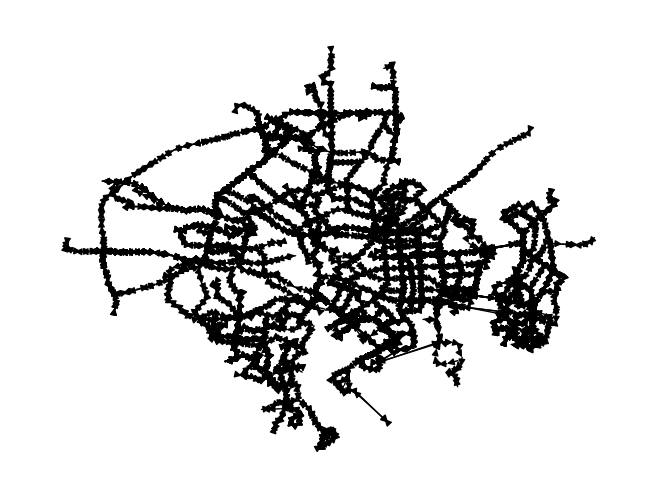

In [42]:
nx.draw(tokyo_bus_network, pos = pos_bus_stops, node_size = 0)

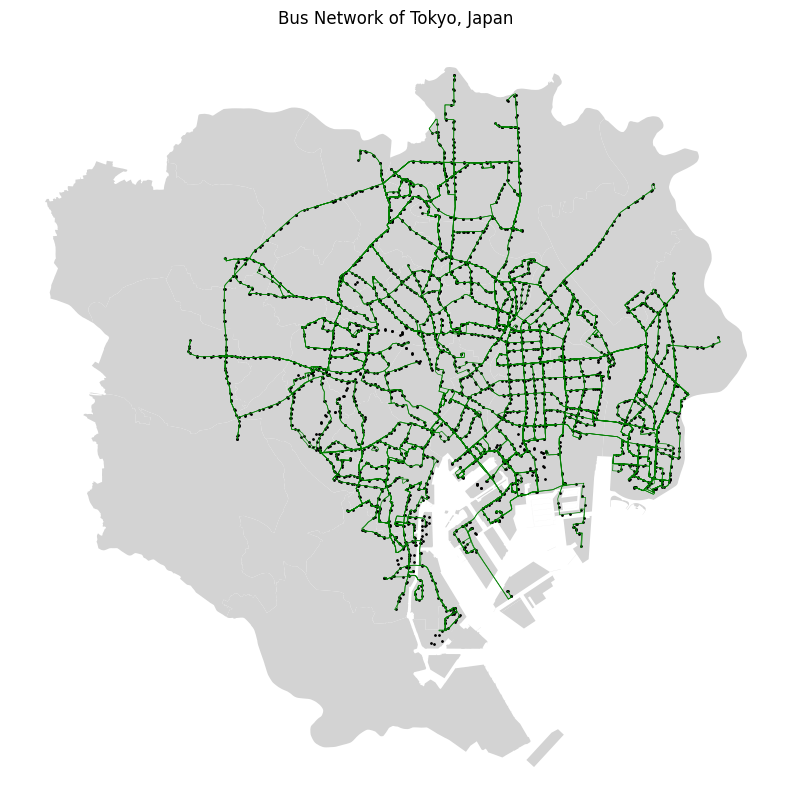

In [13]:
# plot the network
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
bus_edges.plot(ax = ax, color = 'green', linewidth = 0.5)
tokyo_geom.plot(ax = ax, color = 'lightgray')
stops_gdf_tokyo.plot(ax = ax, markersize = 1, color = 'black')

plt.title("Bus Network of Tokyo, Japan")
plt.axis('off')

plt.savefig('slides/img/bus_network_tokyo.png', bbox_inches = 'tight')

## Load rail data

In [14]:
# load data
historic_path = os.path.join('data', 'rail_network_data', 'N05-22_GML')

stations = gpd.read_file(os.path.join(historic_path, 'N05-22_Station2.shp'))
rail_routes = gpd.read_file(os.path.join(historic_path, 'N05-22_RailroadSection2.shp'))

# make years into int
years = ['N05_004', 'N05_005b', 'N05_005e']
for y in years:
    stations[y] = stations[y].astype(int)
    rail_routes[y] = rail_routes[y].astype(int)

# extract current routes
rail_routes = rail_routes[rail_routes['N05_005e'] > 2023].copy().to_crs(crs)
stations = stations[stations['N05_005e'] > 2023].copy().to_crs(crs)

# add coordinates
stations['x'] = stations['geometry'].x
stations['y'] = stations['geometry'].y

# filter lines that intersect with the City
line_sets = set([(r['N05_003'], r['N05_002']) for idx, r in rail_routes[rail_routes.intersects(tokyo_geom.unary_union)].iterrows()])

# # remove the bullet train
# line_sets = [l for l in line_sets if l[1] != '東海道新幹線']

# extract stations and lines on the set of lines
rail_routes_tokyo = rail_routes[rail_routes[['N05_003', 'N05_002']].apply(tuple, axis = 1).isin(line_sets)]
stations_tokyo = stations[stations[['N05_003', 'N05_002']].apply(tuple, axis = 1).isin(line_sets)]


In [15]:
# create edge list of the lines within Tokyo
edge_list_tokyo = create_edge_list(rail_routes_tokyo, stations_tokyo, tolerance = 10)

# create reverse edges and add back to edge_list
edge_list_tokyo_reverse = edge_list_tokyo.copy()

# switch source and target
edge_list_tokyo_reverse.rename(columns = {'source_name': 'target_name', 'target_name': 'source_name', 'source_ID': 'target_ID', 'target_ID': 'source_ID'})
edge_list_tokyo_reverse['geometry'] = edge_list_tokyo_reverse['geometry'].reverse()

# concatenate the two dataframes together
edge_list_tokyo_directed = pd.concat([edge_list_tokyo, edge_list_tokyo_reverse], ignore_index = True)

## extract the edges that intersect with the area
edge_list_tokyo_filtered = edge_list_tokyo[edge_list_tokyo.intersects(tokyo_geom.unary_union)].copy()

# create edges for transfers
tokyo_transfers = transfer_edge_list(stations_tokyo)

Processing 東日本旅客鉄道（旧国鉄）
Working on 東北新幹線
Working on 東北線
Working on 総武線
Working on 京葉線
Working on 中央線
Working on 東海道線
Working on 山手線
Working on 赤羽線
Working on 常磐線
Finished 東日本旅客鉄道（旧国鉄）
Processing 京成電鉄
Working on 本線
Working on 押上線
Working on 金町線
Working on 成田空港線
Finished 京成電鉄
Processing 東武鉄道
Working on 伊勢崎線
Working on 亀戸線
Working on 大師線
Working on 東上本線
Finished 東武鉄道
Processing 北総鉄道
Working on 北総線
Finished 北総鉄道
Processing 埼玉高速鉄道
Working on 埼玉高速鉄道線
Finished 埼玉高速鉄道
Processing 首都圏新都市鉄道
Working on 常磐新線
Finished 首都圏新都市鉄道
Processing 小田急電鉄
Working on 小田原線
Finished 小田急電鉄
Processing 京王電鉄
Working on 京王線
Working on 井の頭線
Finished 京王電鉄
Processing 京浜急行電鉄
Working on 本線
Working on 空港線
Finished 京浜急行電鉄
Processing 西武鉄道
Working on 池袋線
Working on 西武有楽町線
Working on 豊島線
Working on 新宿線
Finished 西武鉄道
Processing 東京都
Working on 1号線浅草線
Working on 6号線三田線
Working on 10号線新宿線
Working on 12号線大江戸線
Working on 上野懸垂線
Working on 日暮里・舎人ライナー
Working on 荒川線
Finished 東京都
Processing 東京地下鉄
Working on 4号線丸ノ内線
Working on 4号線丸ノ内線分岐線
W

In [16]:
# create network from edge list
tokyo_rail_network = nx.from_pandas_edgelist(
    edge_list_tokyo_filtered,
    source = 'source_ID',
    target = 'target_ID',
    edge_attr = ['N05_003', 'N05_002', 'distance', 'geometry'],
    create_using = nx.MultiDiGraph
)

# add name to network
tokyo_rail_network.graph.update({'name': 'rail'})

# add edge attribute
nx.set_edge_attributes(tokyo_rail_network, values = 'rail', name = 'type')

# add node information
# extract the required fields and make the ids the index
# then add to the network
tokyo_rail_network.add_nodes_from(
    (n, dict(d)) for n, d in stations_tokyo.set_index('N05_006')[['N05_003', 'N05_002', 'N05_011', 'x', 'y', 'geometry']].iterrows() if n in tokyo_rail_network.nodes()
)

# get the position
pos_stations = {
    row['N05_006']: (row['x'], row['y']) for i, row in stations_tokyo.reset_index().iterrows() if row['N05_006'] in tokyo_rail_network.nodes()
}

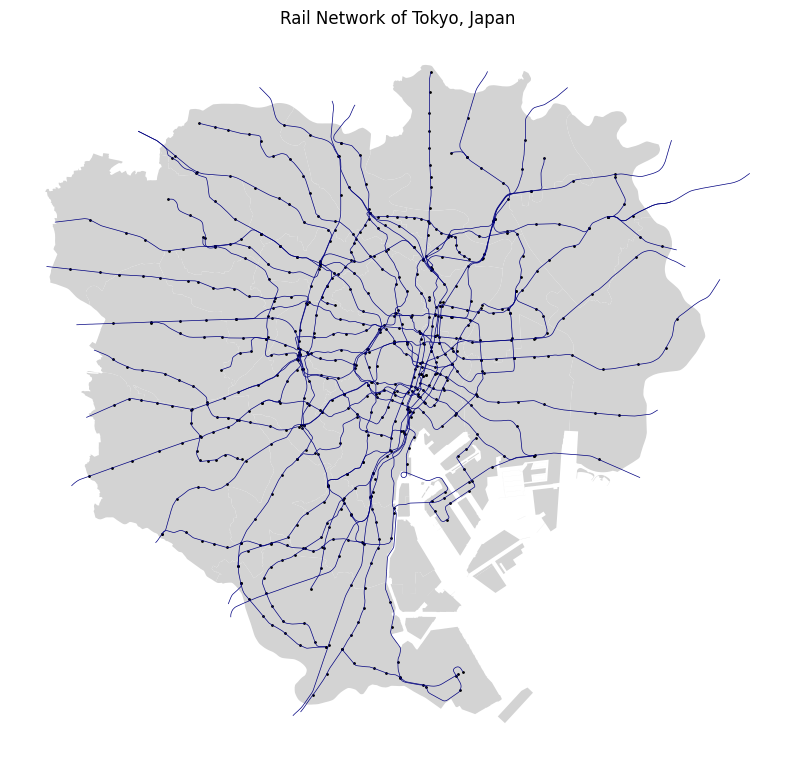

In [17]:
# plot the network
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
edge_list_tokyo_filtered[~edge_list_tokyo_filtered['N05_002'].str.contains('新幹線')].plot(ax = ax, color = 'navy', linewidth = 0.5)
tokyo_geom.plot(ax = ax, color = 'lightgray')
stations_tokyo[stations_tokyo.intersects(tokyo_geom.unary_union)].plot(ax = ax, markersize = 1, color = 'black')

plt.title("Rail Network of Tokyo, Japan")
plt.axis('off')

plt.savefig('slides/img/rail_network_tokyo.png', bbox_inches = 'tight')

## Load Street Data

In [ ]:
# load data from network
tokyo_street_network = ox.graph_from_polygon(tokyo_geom.to_crs('EPSG:4326').unary_union, network_type = 'all')

# project to EPSG:6677
tokyo_street_network = ox.projection.project_graph(tokyo_street_network, to_crs = crs)

# name the street network
tokyo_street_network.graph.update({'name': 'street'})

In [4]:
# load data from network
tokyo_street_network_tertiary = ox.graph_from_polygon(
    tokyo_geom.to_crs('EPSG:4326').unary_union, 
    custom_filter = '["highway" ~ "motorway|trunk|primary|secondary|tertiary|motorway_link|trunk_link|primary_link|secondary_link|tertiary_link"]',
    simplify = False
)

# project to EPSG:6677
tokyo_street_network_tertiary = ox.projection.project_graph(tokyo_street_network_tertiary, to_crs = crs)


In [5]:
# add time weights
tokyo_street_network_tertiary = ox.routing.add_edge_speeds(tokyo_street_network_tertiary)

# simplify based on the speed
tokyo_street_network_simplified = ox.simplify_graph(tokyo_street_network_tertiary, edge_attrs_differ = ['highway', 'speed_kph', 'name'])

# calculate the time
tokyo_street_network_simplified = ox.routing.add_edge_travel_times(tokyo_street_network_simplified)

# convert to minutes
for u,v,k,d in tokyo_street_network_simplified.edges(data = True, keys = True):
    d['travel_time_mins'] = d['travel_time'] / 60

In [9]:
# calibrate using the average observed speed
mean_speed = sum([d['length'] * d['speed_kph'] for u,v,k,d in tokyo_street_network_simplified.edges(data = True, keys = True)]) / sum([d['length'] for u,v,k,d in tokyo_street_network_simplified.edges(data = True, keys = True)])

# the actual mean speed from the census
actual_speed = 19.0

for u,v,k,d in tokyo_street_network_simplified.edges(data = True, keys = True):
    d['speed_kph_calib'] = d['speed_kph'] * actual_speed / mean_speed
    d['travel_time_calib'] = d['travel_time'] * mean_speed / actual_speed    
    d['travel_time_mins_calib'] = d['travel_time_mins'] * mean_speed / actual_speed

print(f'Calibrated the mean from {mean_speed} to {actual_speed}')

Calibrated the mean from 39.92581609036763 to 19.0


In [10]:
# # save to graphml format using OSMNX
ox.io.save_graphml(tokyo_street_network_simplified, 'data/tokyo/drive_network_updated.graphml', encoding = 'utf-8')

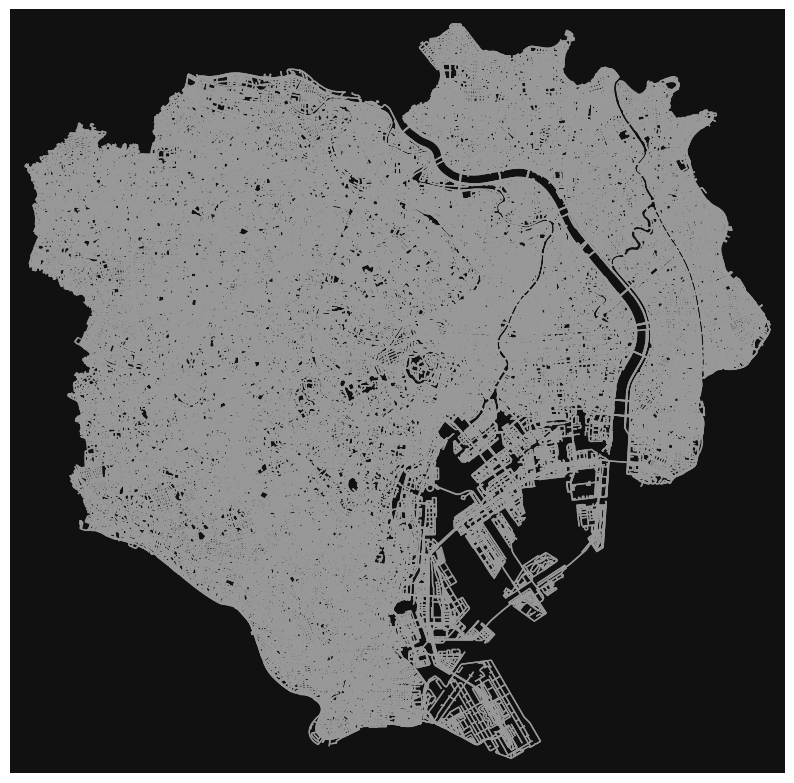

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [31]:
ox.plot_graph(tokyo_street_network, figsize = (10, 10), node_size = 0, save = True, filepath = 'slides/img/street_network.png')

In [32]:
# load the road network for cars
tokyo_vehicle_network = ox.graph_from_polygon(tokyo_geom.to_crs('EPSG:4326').unary_union, network_type = 'drive')

# project to EPSG:6677
tokyo_vehicle_network = ox.projection.project_graph(tokyo_vehicle_network, to_crs = crs)

# save to graphml format using OSMNX
ox.io.save_graphml(tokyo_vehicle_network, 'data/tokyo/drive_network.graphml', encoding = 'utf-8')

## Create Transit Links

In [ ]:
# create rail transit link - takes 415 minutes
rail_transit_links = transit_links(tokyo_rail_network, tokyo_street_network)
bus_transit_links = transit_links(tokyo_bus_network, tokyo_street_network)

In [ ]:
# combine layers
layers = [tokyo_bus_network, tokyo_rail_network, tokyo_street_network]
transfers = [bus_transit_links, rail_transit_links]

# create network
tokyo_multilayer = create_multilayer_network(layers, transfers)

In [ ]:
# save to graphml format using OSMNX
ox.io.save_graphml(tokyo_multilayer, 'data/tokyo/multilayer_edit.graphml', encoding = 'utf-8')